In [12]:
%load_ext autoreload
%matplotlib inline  
%autoreload 
# coding: utf-8
__author__ = "Ewan Machefaux"
__copyright__ = "Copyright (C) 2016 Free Software Foundation"
__credits__ = ["Pierre-Elouan Rethore, Juan Pablo Murcia Leon, Rolf-Erik Keck"]
__license__ = "GNU AFFERO GENERAL PUBLIC LICENSE"
__version__ = "0.1"
__maintainer__ = "Ewan Machefaux, Pierre-Elouan Rethore"
__email__ = "ewan.machefaux@gmail.com, pire@dtu.dk"
__status__ = "Beta"

"""
    Disclaimer:
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE
WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR
OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
"""

"""
    A simple and standalone implementation of the Dynamic Wake Meandering model applied to wind farms. Example RUN PYTHON SCRIPT
    @moduleauthor:: Ewan Machefaux <ewan.machefaux@gmail.com>
    References:
    [1] Larsen, G. C. et al, Wake meandering: a pragmatic approach. Wind Energy, 11(4), 377–395. http://doi.org/10.1002/we.267
    [2] Madsen, H. A. et al, Calibration and Validation of the Dynamic Wake Meandering Model for Implementation in an Aeroelastic Code. Journal of Solar Energy Engineering, 132(4), 041014. http://doi.org/10.1115/1.4002555
    [3] Larsen, G. C., Machefaux, E. et al.  Wake meandering under non-neutral atmospheric stability conditions - theory and facts. 2015 Journal of Physics: Conference Series, 625(1), 012036. http://doi.org/10.1088/1742-6596/625/1/012036
    [4] Larsen, T. J. et al, Validation of the Dynamic Wake Meander Model for Loads and Power Production in the Egmond aan Zee Wind Farm, 2011 Wind Energy. 1–19. http://doi.org/10.1002/we
2015    [5] Keck, R.-E. Validation of the standalone implementation of the dynamic wake meandering model for power production. (2015) Wind Energy, 18(9), 1579–1591. http://doi.org/10.1002/we.1777
2011.    [6] Keck et al., Implementation of a Mixing Length Turbulence Formulation Into the Dynamic Wake Meandering Model, Journal of Solar Energy Engineering, Volume 134, Issue 2, 021012 (13 pages), 2011.
2012.    [7] Keck et al., Two Improvements to the Dynamic Wake Meandering Model: Including the Effects of Atmospheric Shear on Wake Turbulence and Incorporating Turbulence Build-up in a Row of Wind Turbines, Journal of Wind Energy 2012.
2013.a    [8] Keck et al., On Atmospheric Stability in the Dynamic Wake Meandering Model,Journal of wind energy January 2013.
2013.b    [9] Keck et al., A consistent turbulence formulation for the dynamic wake meandering model in the atmospheric boundary layer, PhD thesis, DTU Wind Energy PhD-0012 (EN), July 2013.
2014     [10] Keck, et al, A pragmatic approach to wind farm simulations using the dynamic wake meandering model. 2014 Wind Energy, 18, 1671–1682. http://doi.org/10.1002/we
    [11] Machefaux, E. et al, Engineering models for merging wakes in wind farm optimization applications.
    [12] Larsen, G. C. A simple stationary semi-analytical wake model, (2009) 1713(August), 1–21.
"""
import sys
sys.path.append("../src/") 
import numpy as np
import fusedwake.WindFarm as wf # An offshore wind farm model Juan P. Murcia <jumu@dtu.dk>
import fusedwake.WindTurbine as wt # An offshore wind farm model Juan P. Murcia <jumu@dtu.dk>
from fusedwake.sdwm.DWM_flowfield_farm import DWM_main_field_model
from fusedwake.sdwm.DWM_GClarsenPicks import get_Rw
from fusedwake.sdwm.DWM_init_dict import init
import sys, getopt
import time
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
def sDWM(**kwargs):
    """
         Main wrapper to the core flow field DWM model
         This function:
         1) handles inputs arguments,
         2) set up defaults values,
         3) call the wind farm layout model,
         4) create the wake tree by calling the expansion of the GCL model
         5) main loop run for each turbine from most upstream to the most downstream in flow coordinate system
    """
    WD = kwargs.get('WD')
    WS = kwargs.get('WS')
    TI = kwargs.get('TI') 
    WTcoord = kwargs.get('WTcoord') 
    WTG = kwargs.get('WTG') 
    HH = kwargs.get('HH') 
    R = kwargs.get('R') 
    stab = kwargs.get('stab') 
    accum = kwargs.get('accum') 

    ttt = time.time()

    # Load wind turbine and wind farm
    WT = wt.WindTurbine('Windturbine','../WT-data/'+WTG+'/'+WTG+'_PC.dat',HH,R)
    WF = wf.WindFarm('Windfarm',WTcoord,WT)

    print '***** sDWM v'+ __version__+' // WF: '+str(WF.nWT)+' WT(s) / WD '+str(WD)+'deg / WS '+str(WS)+' m/s / TI '+str(TI)+' / accumulation: '+accum+'  ******************'

    # Scaling wind farm to NREL's rotor size
    if 'Lill' in WTcoord:
        WF.vectWTtoWT=WF.vectWTtoWT*(WT.R/46.5) # 46.5 is the Lillgrund nominal radius of SWT turbine

    # Compute distance WT to WT in mean flow coordinate system
    distFlowCoord, nDownstream, id0= WF.turbineDistance(WD)

    # Init dictionnaries
    deficits, turb, inlets_ffor, inlets_ffor_deficits,inlets_ffor_turb,out, DWM, ID_waked, ID_wake_adj, Farm_p_out, WT_p_out, Vel_out, Pos_out=init(WF)

    # Extreme wake to define WT's in each wake, including partial wakes. This is a call to GCL expansion model [12]
    ID_wake = {id0[i]:(get_Rw(x=distFlowCoord[0,id0[i],:],
                              R = 2. * WF.WT.R,
                              TI=TI,
                              CT=WT.get_CT(WS),
                              pars=[0.435449861,0.797853685,-0.124807893,0.136821858,15.6298,1.0])>\
               np.abs(distFlowCoord[1,id0[i],:])).nonzero()[0] \
               for i in range(WF.nWT)}

    ## Main DWM loop over turbines
    for iT in range(WF.nWT):
        print 'Simulating turbine '+ str(iT+1) +'/'+str(WF.nWT)
        # Define flow case geometry
        cWT = id0[iT]
        #Radial coordinates in cWT for wake affected WT's
        x=distFlowCoord[0,cWT,ID_wake[cWT]]
        C2C   = distFlowCoord[1,cWT,ID_wake[cWT]]
        index_orig=np.argsort(x)
        x=np.sort(x)
        row= ID_wake[id0[iT]][index_orig]
        C2C=C2C[index_orig]

        # wind turbine positions
        Pos_out[iT,0] = ((WF.pos[0,cWT]-min(WF.pos[0,:]))/(2.*WF.WT.R))*(WT.R/46.5)
        Pos_out[iT,1] = ((WF.pos[1,cWT]-min(WF.pos[1,:]))/(2.*WF.WT.R))*(WT.R/46.5)

        # Wrapping the DWM core model with inputs
        par={
         'WS'         : WS, # wind speed [m/s]
         'TI'         : TI, # turbulence intensity
         'atmo_stab'  : stab, # atmospheric stability VU, U ,NU, N, NS, S, VS
         'WTG'        : WTG, # wind turbine name
         'WTG_spec'   : WT, # class holding wind turbine specifications
         'wtg_ind'    : row, # turbine index
         'hub_z'      : x/(2*WF.WT.R), # set up location of downstream turbines in flow direction
         'hub_x'      : np.ceil((3*(max(abs(C2C))+WF.WT.R))/WF.WT.R)*0.5+C2C/(WF.WT.R), # set up lateral displacements of downstream turbines
         'C2C'        : C2C, # parse the "Center to Center" distance between hubs
         'lx'         : np.ceil((3.*(max(abs(C2C))+WF.WT.R))/WF.WT.R),  # set up length of the domain in lateral coordinates in rotor diameter [D]
         'ly'         : np.ceil((3.*(max(abs(C2C))+WF.WT.R))/WF.WT.R),  # set up length of the domain in longitudinal in rotor diameter [D]
         'accu_inlet' : True, # specify whether inlet propagation is enabled (more accurate but slows down simulations), if disable, it behaves like HAWC2-DWM
         'accu'       : accum, # type of wake accumulation (linear, dominant [4] or quadratic)
         'full_output': True # Flag for generating the complete output with velocity deficit scalars (larger memory foot print if enabled)
        }
        ID_wake_adj[str(id0[iT])]=row
        aero, meta, mfor, ffor, DWM, deficits,inlets_ffor,inlets_ffor_deficits, \
        inlets_ffor_turb,turb, out,ID_waked = DWM_main_field_model(ID_waked,deficits,inlets_ffor,inlets_ffor_deficits,
                                                                   inlets_ffor_turb,turb,DWM,out,**par)

        # Total power
        Farm_p_out= Farm_p_out+out[str(meta.wtg_ind[0])][0] # based on BEM,# Farm_p_out= Farm_p_out+out[str(meta.wtg_ind[0])][4] # based on power curve
        # Power by each turbine
        WT_p_out[iT]=out[str(meta.wtg_ind[0])][0]
        Vel_out[iT]=out[str(meta.wtg_ind[0])][1]
    elapsedttt = time.time() - ttt
    print '***** sDWM v'+ __version__+' // Farm prod. is: %4.2f kW, %i WT(s) : %s -- in %4.2f sec *************' %(Farm_p_out,WF.nWT,np.array_str(WT_p_out),elapsedttt)
    return Farm_p_out,WT_p_out,Vel_out,Pos_out,WF,WT,aero, meta, mfor, ffor, DWM, deficits,inlets_ffor,inlets_ffor_deficits, inlets_ffor_turb,turb, out,ID_waked

In [15]:
# In this example, we perform plant flow calculation of the offshore wind farm Lillgrund.
# The official Siemens turbine characteristics being not accessible, we use the generic NREL5MW turbine instead
# and scale the wind farm geometry to keep the same turbine relative spacing. However the hub height of the NREL 5MW is kept
# at his design value.

inputs={'WD':120.0,
'WS':9.0,
'TI':0.06,
# WTcoord='../data/Lill_A04B04C04.dat'; '../data/Lill_full.dat'
# 'WTcoord':'../data/Lill_A04.dat',
'WTcoord':'../data/Lill_full.dat',
'WTG':'NREL5MW',
'HH':90.0,
'R':63.0,
'stab':'N',
'accum':'dominant'}
    
Farm_p_out,WT_p_out,Vel_out,Pos_out,WF,WT,aero, meta, mfor, ffor, DWM, deficits,inlets_ffor,inlets_ffor_deficits, inlets_ffor_turb,turb, out,ID_waked= sDWM(**inputs)



***** sDWM v0.1 // WF: 48 WT(s) / WD 120.0deg / WS 9.0 m/s / TI 0.06 / accumulation: dominant  ******************
Simulating turbine 1/48
Simulating turbine 2/48
Simulating turbine 3/48
Simulating turbine 4/48
Simulating turbine 5/48
Simulating turbine 6/48
Simulating turbine 7/48
Simulating turbine 8/48
Simulating turbine 9/48
Simulating turbine 10/48
Simulating turbine 11/48
Simulating turbine 12/48
Simulating turbine 13/48
Simulating turbine 14/48
Simulating turbine 15/48
Simulating turbine 16/48
Simulating turbine 17/48
Simulating turbine 18/48
Simulating turbine 19/48
Simulating turbine 20/48
Simulating turbine 21/48
Simulating turbine 22/48
Simulating turbine 23/48
Simulating turbine 24/48
Simulating turbine 25/48
Simulating turbine 26/48
Simulating turbine 27/48
Simulating turbine 28/48
Simulating turbine 29/48
Simulating turbine 30/48
Simulating turbine 31/48
Simulating turbine 32/48
Simulating turbine 33/48
Simulating turbine 34/48
Simulating turbine 35/48
Simulating turbine 3

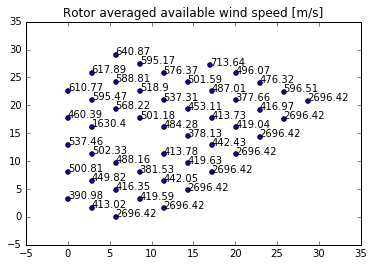

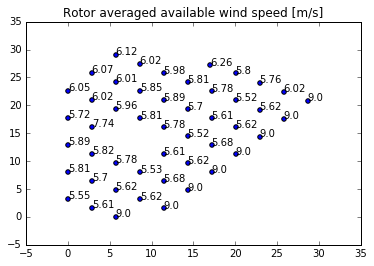

In [16]:
fig, ax = plt.subplots()
ax.scatter(Pos_out[:,0],Pos_out[:,1])

for i, txt in enumerate(WT_p_out):
    ax.annotate(txt, (Pos_out[i,0],Pos_out[i,1]))
plt.title('Rotor averaged available wind speed [m/s]')
fig, ax = plt.subplots()
ax.scatter(Pos_out[:,0],Pos_out[:,1])

for i, txt in enumerate(Vel_out):
    ax.annotate(txt, (Pos_out[i,0],Pos_out[i,1]))
plt.title('Rotor averaged available wind speed [m/s]')

/Users/pe/.virtualenvs/fusedwake/lib/python2.7/site-packages/ipykernel/__main__.py:35: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


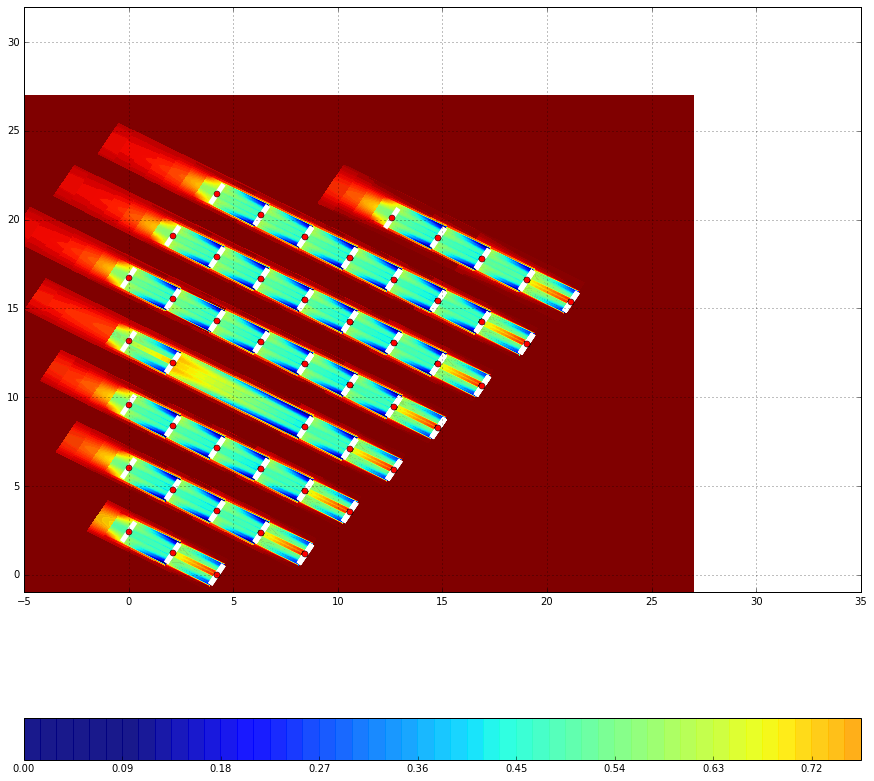

In [17]:
# Plot superposition of single DWM computations to reproduce global flow field

WD=inputs['WD']
distFlowCoord, nDownstream, id0= WF.turbineDistance(WD)
angle = np.radians(270.+WD+270.)
ROT = np.array([[np.cos(angle), np.sin(angle)],\
      [-np.sin(angle), np.cos(angle)]])

plt.figure(figsize=(15, 15))
# init U0 everywhere
Xi,Yi=np.meshgrid(np.arange(-5.,28.,1),np.arange(-5.,28.,1))
U0=np.ones((len(Xi),len(Yi)))
im=plt.contourf(Xi,Yi,U0,50,cmap=plt.cm.jet,linewidth=0.1,alpha=1,zorder=-1,vmin=0.5, vmax=1.)
plt.hold('True')
for iT in range(WF.nWT):
# for iT in [0]:
    cWT = id0[iT]
#     print cWT
    x = (WF.pos[0,cWT]-min(WF.pos[0,:]))/(2.*WF.WT.R)
    y = (WF.pos[1,cWT]-min(WF.pos[1,:]))/(2.*WF.WT.R)
    xi = (WF.pos[0,cWT]-WF.WT.R-min(WF.pos[0,:]))/(2.*WF.WT.R)
    xu = (WF.pos[0,cWT]+WF.WT.R-min(WF.pos[0,:]))/(2.*WF.WT.R)
#     Xr= np.hstack((xi,xu))
    Xr=np.asarray([-0.5, 0.5])
    Yr=np.asarray([0, 0])
    
    Xrg=  Xr*np.cos(angle) + Yr*np.sin(angle) 
    Yrg= -Xr*np.sin(angle) + Yr*np.cos(angle)
#     print Xrg
    XX=DWM[str(cWT)].x_vec
    ZZ=DWM[str(cWT)].z_vec
    X,Z=np.meshgrid(DWM[str(cWT)].x_vec, DWM[str(cWT)].z_vec)
    Xg = X*np.cos(angle) + Z*np.sin(angle) 
    Zg = -X*np.sin(angle) + Z*np.cos(angle)
    
    wake=DWM[str(cWT)].WS_axial_ffor[:,len(DWM[str(cWT)].x_vec)/2.,:]
    wake[wake>=1]=np.nan
    #print wake
    im=plt.contourf(Xg.T+x,Zg.T+y,wake,50,cmap=plt.cm.jet,linewidth=0.1,alpha=0.9,vmin=0.1, vmax=1.)#     print np.amax(DWM[str(ID_wake[iT][0])].WS_axial_ffor[:,len(DWM[str(ID_wake[iT][0])].x_vec)/2.,:])
    plt.hold('True')
    for i_z in range(len(ZZ)):
        XZ=np.ones(len(XX))*ZZ[i_z]
        res=np.dot(ROT,np.vstack((XX,XZ)))
#         resc=np.dot(ROT,np.vstack((Xr,np.ones(len(Xr))*y)))
        plt.hold('True')
        plt.plot(Xrg+x,Yrg+y,'w-',linewidth=5)
        plt.plot(x,y,'ro')
plt.ylim((-1.,32))
plt.xlim((-5.,35))
plt.grid('on')
plt.colorbar(im, orientation='horizontal')

